In [16]:
from simpleimage import SimpleImage
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# Working under assumption that the first lane is the protein ladder, the second is control, then the protein samples

# Identifies the pixel tuples for the start and end x-pixel values for each lane

def separateLanes(image, num_lanes, first_lane):
  lane_width = (image.width - first_lane) / (num_lanes - 1)
  pixels_x = [(int(i * lane_width + first_lane), int((i + 1) * lane_width - 1 + first_lane)) for i in range(num_lanes - 1)]
  return pixels_x

# Calculates band intensity within each lane and highlights identified pixels

def getBandIntensity(image, imageDraw, pixels, color):
  if color == 'red':
    collect = False
    intensity = 0
    for y in range(image.height):
      row_intensity = 0
      for x in range(pixels[0], pixels[1]):
        pixel = image.get_pixel(x, y)
        if pixel.red > 50:
          row_intensity += pixel.red
          if collect:
            intensity += pixel.red
            imageDraw[y,x] = (0, 0, 255)
      if collect == False and row_intensity/(pixels[1] - pixels[0]) > 30:
        collect = True
      if collect == True and row_intensity/(pixels[1] - pixels[0]) < 30: # Arbitrary threshold
        return intensity
  if color == 'green':
    collect = False
    intensity = 0
    for y in range(image.height):
      row_intensity = 0
      for x in range(pixels[0], pixels[1]):
        pixel = image.get_pixel(x, y)
        if pixel.green > 50:
          row_intensity += pixel.green
          if collect:
            intensity += pixel.red
            imageDraw[y,x] = (0, 255, 0)
      if collect == False and row_intensity/(pixels[1] - pixels[0]) > 30:
        collect = True
      if collect == True and row_intensity/(pixels[1] - pixels[0]) < 30:
        return intensity

# Finds the first lane in order to exclude the ladder from analysis by finding the
# first column of pixels that are relatively dark

def findFirstLane(image):
  second = False
  for x in range(image.width):
    sum_pixels = 0
    for y in range(image.height):
      pixel = image.get_pixel(x, y)
      sum_pixels += pixel.red
    avg_pixel = sum_pixels/image.height
    if second == True and avg_pixel < 15: # Arbitrary threshold found by experimental techniques
      return x
    if avg_pixel > 20:
      second = True
  print("Ladder not found.")

# Main function

def analyzeConcentrations(image):
  analysisIMG = SimpleImage(image)
  displayIMG = cv2.imread(image)

  # User input for number of lanes, color channel, and normalization information
  num_lanes = int(input("How many lanes are in your Western (including ladder control)?\n"))
  color = input("What is the color channel that you are imaging?\n").lower()
  while color != 'green' and color != 'red':
    print(color, "is not a color.")
    color = input("What is the color channel that you are imaging?\n").lower()
  control_concentration = int(input('What is the concentration (in ug/ul) of the control?\n'))
  control_volume = int(input('What volume (in ul) of control did you use?\n'))

  # Identifying lines while excluding ladder
  first_lane = findFirstLane(analysisIMG)
  lanes = separateLanes(analysisIMG, num_lanes, first_lane)

  # Analyzing band intensity and calculating concentration
  for i in range(len(lanes)):
    intensity = getBandIntensity(analysisIMG, displayIMG, lanes[i], color)
    if i == 0: control_intensity = intensity
    else:
      concentration = np.round((intensity / control_intensity * 100), 3)
      print("Sample", i, "Concentration is", concentration, '%')

  # Drawing identified lanes
  for lane in lanes:
    displayIMG = cv2.rectangle(displayIMG, (lane[0], 0), (lane[1], analysisIMG.height), (255, 0, 0), 2)

  cv2_imshow(displayIMG)

In [17]:
analyzeConcentrations('Test_BlotAnalysis.png')

# What are all of the purposes?
# User decides which lane is control
# Normalization

How many lanes are in your Western (including ladder control)?
8


KeyboardInterrupt: ignored

How many lanes are in your Western (including ladder control)?
8


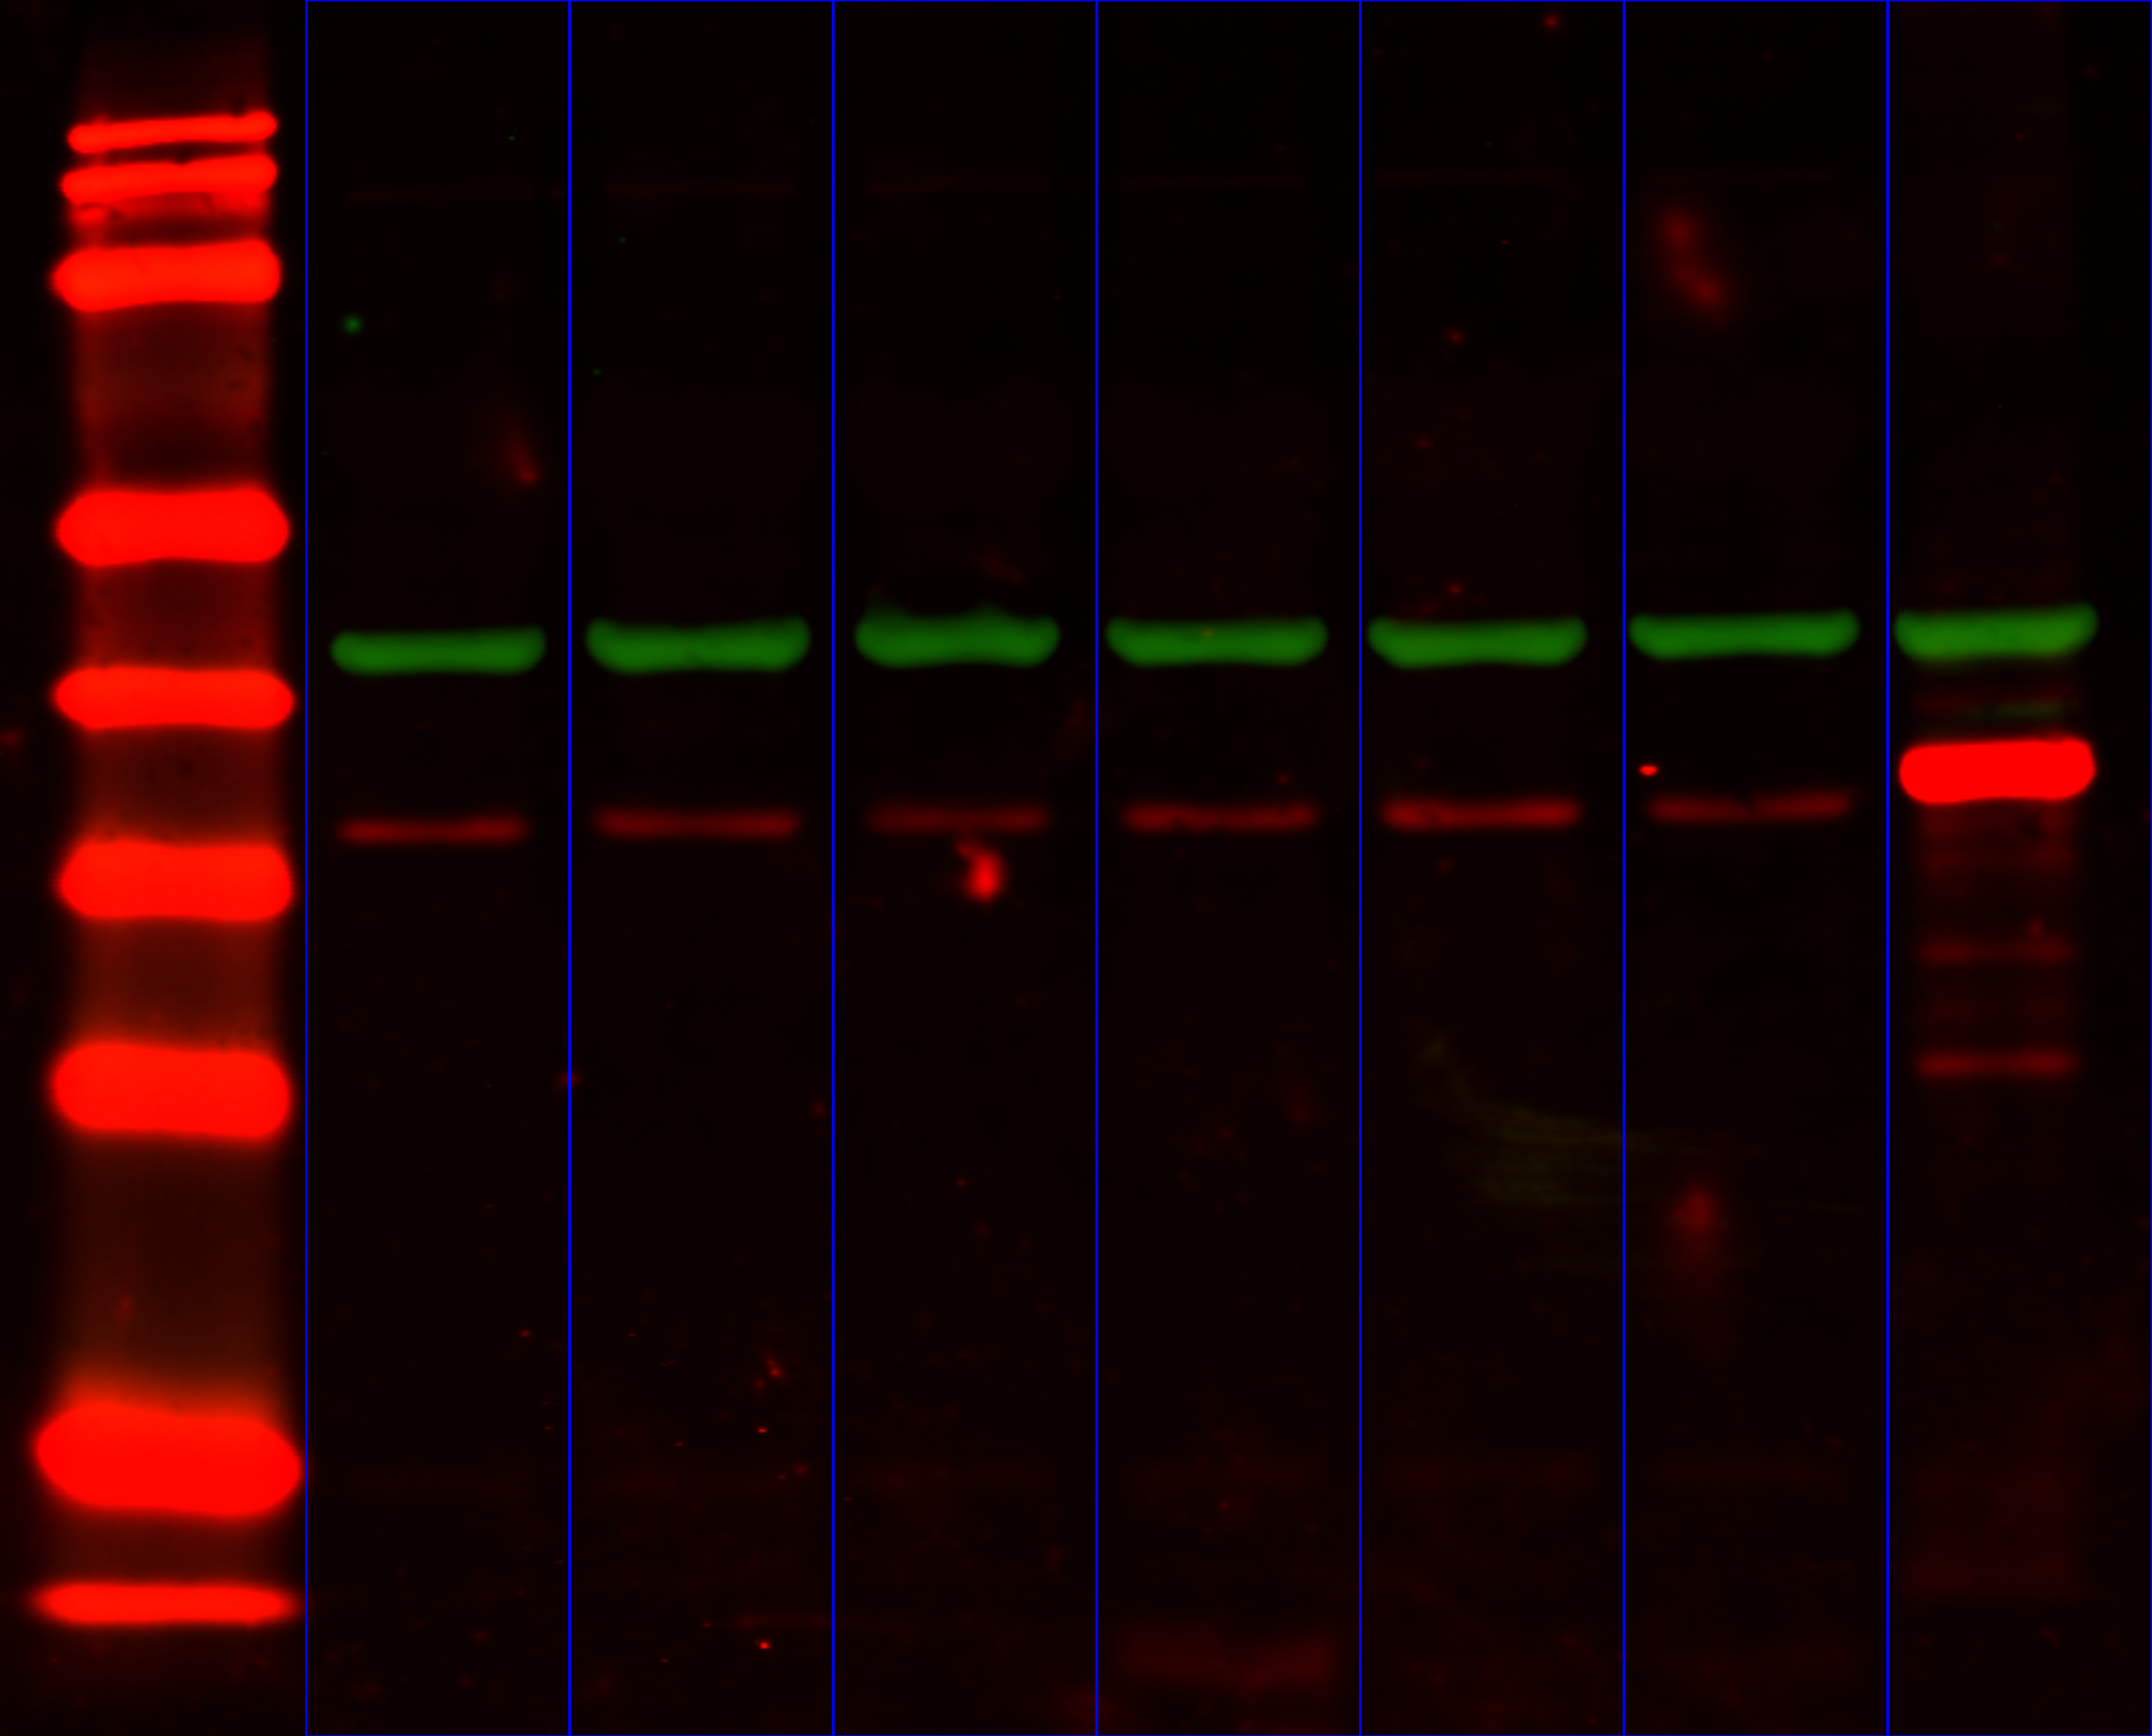

In [ ]:
# TEST SCRIPT TO ENSURE CORRECT LANES
import cv2
from google.colab.patches import cv2_imshow
def test(image):
  img = SimpleImage(image)
  img2 = cv2.imread(image)
  first_lane = findFirstLane(img)
  num_lanes = int(input("How many lanes are in your Western (including ladder control)?\n"))
  lanes = separateLanes(img, num_lanes, first_lane)
  for lane in lanes:
    image = cv2.rectangle(img2, (lane[0], 0), (lane[1], img.height), (255, 0, 0), 2)
  cv2_imshow(image)

test('Test_BlotAnalysis.png')